**Proyecto de series de tiempo alternativo**

- Comprender un dataset nuevo.
- Analizar la serie temporal y estudiar sus características.
- Entrenar un modelo para predecir las ventas a futuro.

**🌱 Cómo iniciar este proyecto**

Sigue las siguientes instrucciones:

- Crea un nuevo repositorio basado en el proyecto de Machine Learning o haciendo clic aquí.
- Abre el repositorio creado recientemente en Codespace usando la extensión del botón de Codespace.
- Una vez que el VSCode del Codespace haya terminado de abrirse, comienza tu proyecto siguiendo las instrucciones a continuación.

**🚛 Cómo entregar este proyecto**

Una vez que hayas terminado de resolver el caso práctico, asegúrate de confirmar tus cambios, haz push a tu repositorio y ve a 4Geeks.com para subir el enlace del repositorio.

**📝 Instrucciones**

**Sistema de predicción de ventas**

Queremos establecer el almacén de nuestra empresa en otra localización y necesitamos estimar el ritmo de las ventas, que desde la creación de la empresa ha ido en aumento, para los próximos meses, a fin de proveer el espacio que necesitaremos.

**Paso 1: Carga del conjunto de datos**
El conjunto de datos se puede encontrar en esta carpeta de proyecto bajo el nombre sales.csv. Puedes cargarlos en el código directamente desde el siguiente enlace:

https://breathecode.herokuapp.com/asset/internal-link?id=2546&path=sales.csv
O descargarlo y añadirlo a mano en tu repositorio.

**Paso 2: Construye y analiza la serie temporal**
Construye la estructura de datos válida para la serie temporal, grafícala y, a continuación, analízala y responde a las siguientes preguntas:

- ¿Cuál es el tensor de la serie temporal?
- ¿Cuál es la tendencia?
- ¿Es estacionaria?
- ¿Existe variabilidad o presencia de ruido?
>
> Nota: Un tensor en una serie temporal es la unidad de tiempo mínima para la cual hay datos. Puede ser cada segundo, minuto, hora, día, semana, mes...
>
**Paso 3: Entrena un ARIMA**
Utiliza los datos de entrenamiento para encontrar la mejor parametrización de tu modelo ARIMA.

**Paso 4: Predice con el conjunto de test**
Ahora utiliza el modelo entrenado con el conjunto de prueba y compara los puntos con los reales. Mide el rendimiento de la serie temporal.

**Paso 5: Guarda el modelo**
Almacena el modelo en la carpeta correspondiente.

Nota: También incorporamos muestras de solución en ./solution.ipynb que te sugerimos honestamente que solo uses si estás atascado por más de 30 minutos o si ya has terminado y quieres compararlo con tu enfoque.

## Imports

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from math import sqrt
import pickle
import warnings
warnings.filterwarnings("ignore")

## Paso 1: cargamos nuestros datos

In [4]:
df = pd.read_csv("../data/raw/sales.csv")
df

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


In [5]:
df.columns = df.columns.str.strip()

In [6]:
df.duplicated().sum()

0

In [7]:
df.isnull().sum()

date     0
sales    0
dtype: int64

## Paso 2: Análisis de una serie temporal

### Buscamos nuestro tensor de tiempo

In [8]:
df['Ndate'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M:%S.%f")
df

,date,sales,Ndate
0,2022-09-03 17:10:08.079328,55.292157,2022-09-03 17:10:08.079328
1,2022-09-04 17:10:08.079328,53.803211,2022-09-04 17:10:08.079328
2,2022-09-05 17:10:08.079328,58.141693,2022-09-05 17:10:08.079328
3,2022-09-06 17:10:08.079328,64.530899,2022-09-06 17:10:08.079328
4,2022-09-07 17:10:08.079328,66.013633,2022-09-07 17:10:08.079328
...,...,...,...
361,2023-08-30 17:10:08.079328,989.600354,2023-08-30 17:10:08.079328
362,2023-08-31 17:10:08.079328,994.987326,2023-08-31 17:10:08.079328
363,2023-09-01 17:10:08.079328,995.814415,2023-09-01 17:10:08.079328
364,2023-09-02 17:10:08.079328,997.350214,2023-09-02 17:10:08.079328


In [9]:
df.dtypes

date             object
sales           float64
Ndate    datetime64[ns]
dtype: object

In [10]:
df.drop(columns=['date'], inplace=True)

In [11]:
df

,sales,Ndate
0,55.292157,2022-09-03 17:10:08.079328
1,53.803211,2022-09-04 17:10:08.079328
2,58.141693,2022-09-05 17:10:08.079328
3,64.530899,2022-09-06 17:10:08.079328
4,66.013633,2022-09-07 17:10:08.079328
...,...,...
361,989.600354,2023-08-30 17:10:08.079328
362,994.987326,2023-08-31 17:10:08.079328
363,995.814415,2023-09-01 17:10:08.079328
364,997.350214,2023-09-02 17:10:08.079328


In [12]:
df.dtypes

sales           float64
Ndate    datetime64[ns]
dtype: object

A continuación visualizaremos la serie temporal para llevar a cabo un análisis visual de la misma:

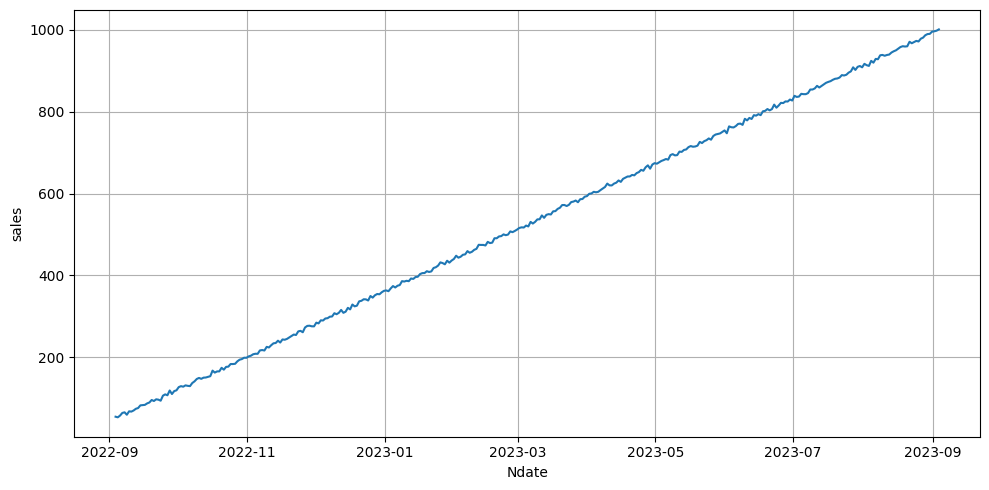

In [13]:
fig, axis = plt.subplots(figsize=(10,5))

sns.lineplot(data=df, x='Ndate', y='sales', ax=axis)
plt.tight_layout()
plt.grid()
plt.show()

### Descomposición de la serie

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   sales   366 non-null    float64       
 1   Ndate   366 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [15]:
df

,sales,Ndate
0,55.292157,2022-09-03 17:10:08.079328
1,53.803211,2022-09-04 17:10:08.079328
2,58.141693,2022-09-05 17:10:08.079328
3,64.530899,2022-09-06 17:10:08.079328
4,66.013633,2022-09-07 17:10:08.079328
...,...,...
361,989.600354,2023-08-30 17:10:08.079328
362,994.987326,2023-08-31 17:10:08.079328
363,995.814415,2023-09-01 17:10:08.079328
364,997.350214,2023-09-02 17:10:08.079328


In [16]:
df.set_index('Ndate', inplace=True)

In [17]:
df

,sales
Ndate,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633
...,...
2023-08-30 17:10:08.079328,989.600354
2023-08-31 17:10:08.079328,994.987326
2023-09-01 17:10:08.079328,995.814415


In [21]:
decompose_result = seasonal_decompose(df, period =7)
decompose_result

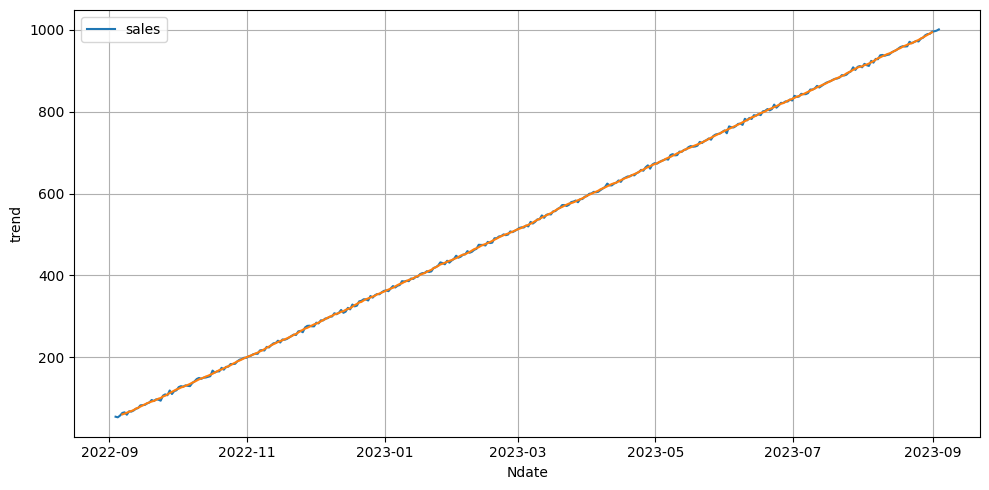

In [22]:
trend = decompose_result.trend

fig, axis = plt.subplots(figsize=(10,5))

sns.lineplot( data = df)
sns.lineplot(data = trend)
plt.tight_layout()
plt.grid()
plt.show()  

#### Observacion


- ¿Cuál es la tendencia?

Nuestro grafico nos dice que nuestra tendencia es claramente ascendente y casi perfectamente lineal, esto significa que las ventas son constantes en el tiempo, sin cambios drasticos, marcando una tendencia fuertemente alcista.

### Análisis de la estacionalidad

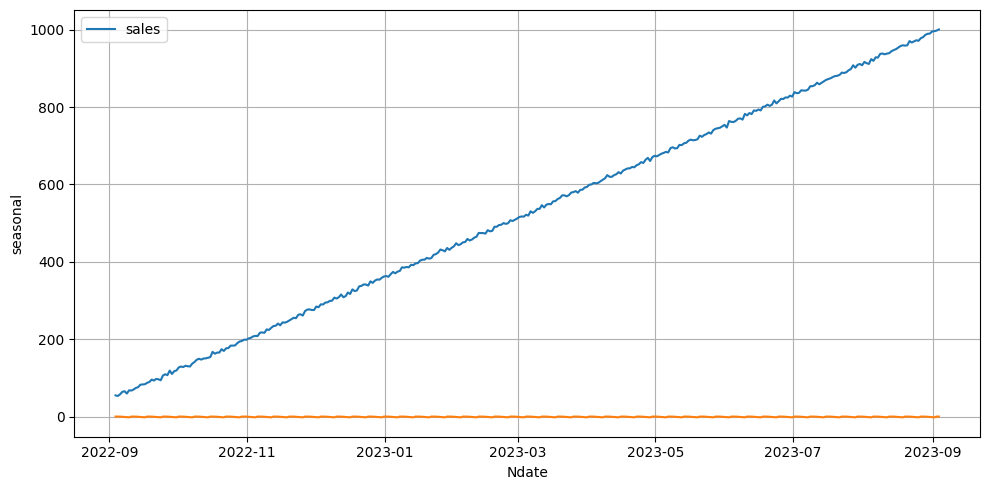

In [23]:
seasonal = decompose_result.seasonal
fig, axis = plt.subplots(figsize=(10,5))
sns.lineplot( data = df)
sns.lineplot(data = seasonal)
plt.tight_layout()
plt.grid()
plt.show()  

#### Observacion

- ¿Es estacionaria? 

El grafico tambien nos dice que no es estacionaria, ya que mantenemos una media constante y lo mas obvio, no se ve una estacionalidad en ningun punto del grafico.

### Prueba de Dickey-Fuller (Dickey-Fuller test)

In [24]:
def test_stationarity(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput= pd.Series(dftest[0:4], index =["Test Statistic", "p-value",
    "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput
test_stationarity(df)

Results of Dickey-Fuller Test:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Aquí podemos ver que el p-value es mayor a 0.05, esto significa que nuestra hipótesis nula NO será rechazada y tomaremos esta serie como no estacionaria.

### Análisis de la variabilidad

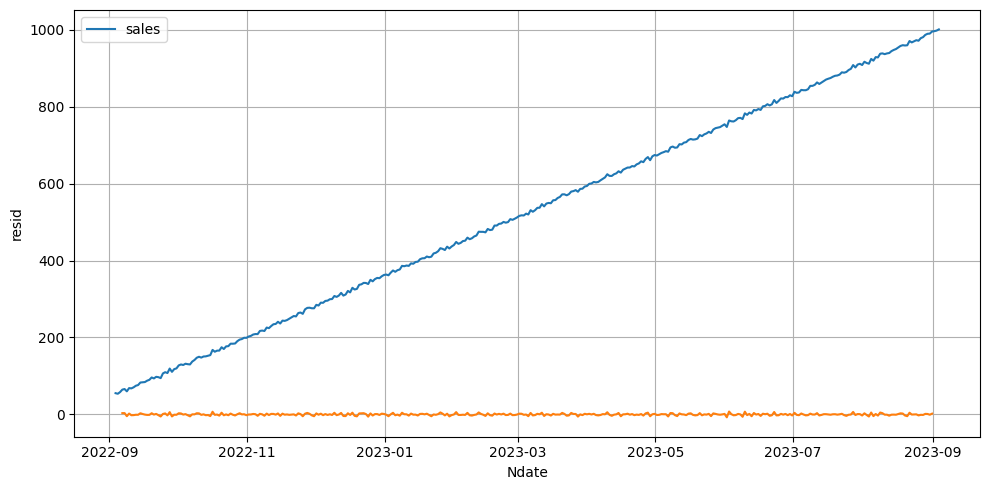

In [25]:
residual = decompose_result.resid

fig, axis = plt.subplots(figsize=(10,5))

sns.lineplot( data = df)
sns.lineplot(data = residual)
plt.tight_layout()
plt.grid()
plt.show()


#### Observacion

- ¿Existe variabilidad o presencia de ruido?

El grafico nos dice, que tenemos ruido pero en menor medida, ya que si observamos con detalle, encontramos pequeñas fluctuaciones alrededor de la linea princial.

### Análisis de la autocorrelación


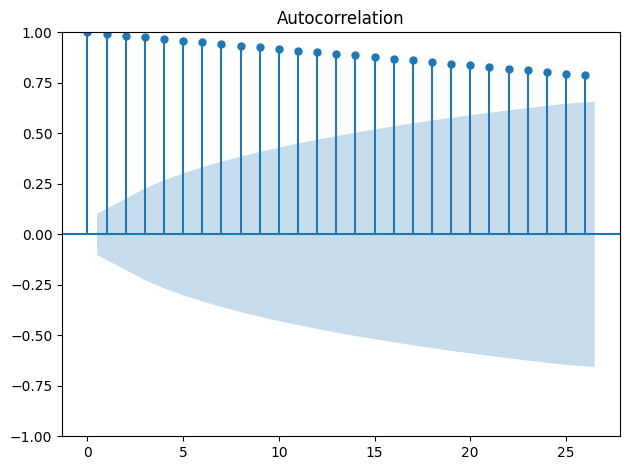

In [26]:
plot_acf(df)

plt.tight_layout()
plt.show()

## Paso 3: Entrenamiento del modelo

### ARIMA model

In [27]:
df_stationary = df.diff().dropna()

test_stationarity(df_stationary)

Results of Dickey-Fuller Test:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

In [28]:
model = auto_arima(df, seasonal=False, trace=True, m=7)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1843.274, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2096.542, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1970.972, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1839.586, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2209.657, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1839.552, Time=0.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1841.532, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1843.586, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1839.607, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1922.648, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 3.541 seconds


In [29]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -915.776
Date:                Tue, 06 Jan 2026   AIC                           1839.552
Time:                        14:45:44   BIC                           1855.152
Sample:                    09-03-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Paso 4: Prediccion del modelo

In [30]:
forecast = model.predict(10)
forecast

2023-09-04 17:10:08.079328    1002.158148
2023-09-05 17:10:08.079328    1004.831668
2023-09-06 17:10:08.079328    1007.423289
2023-09-07 17:10:08.079328    1010.021630
2023-09-08 17:10:08.079328    1012.619419
2023-09-09 17:10:08.079328    1015.217253
2023-09-10 17:10:08.079328    1017.815084
2023-09-11 17:10:08.079328    1020.412915
2023-09-12 17:10:08.079328    1023.010746
2023-09-13 17:10:08.079328    1025.608577
Freq: D, dtype: float64

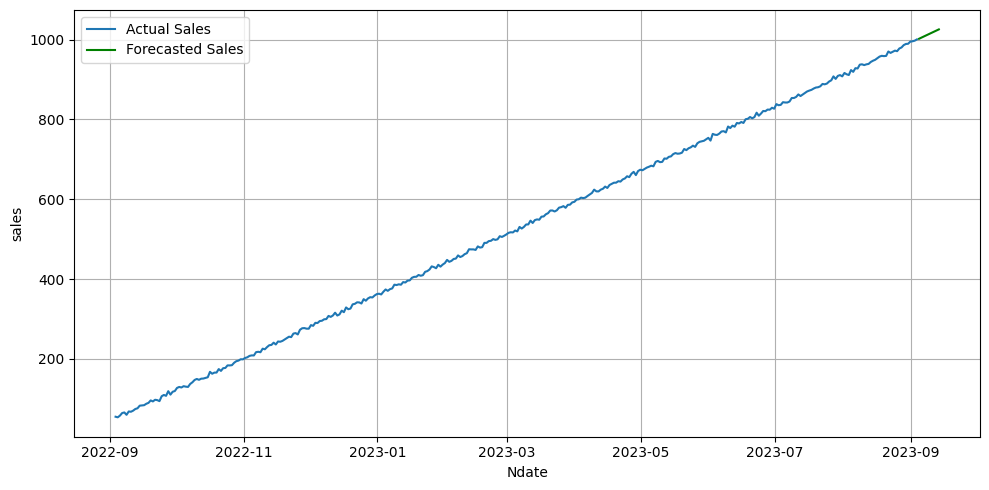

In [31]:
fig, axis = plt.subplots(figsize=(10,5))

sns.lineplot(data=df, x=df.index, y='sales', ax=axis, label='Actual Sales')
sns.lineplot(data=forecast, c="green", ax=axis, label='Forecasted Sales')
plt.tight_layout()
plt.grid()
plt.show()

### ¿Cuál es el tensor de la serie temporal?"

Como ya hemos visto los datos son DIARIOS (366 observaciones en ~1 año)

## Paso 5: Guardar el modelo

In [32]:
with open('../models/10-forecasting-model.pkl', 'wb') as f:
    pickle.dump(model, f)